In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

import numpy as np
import pandas as pd

from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece

In [2]:
cals = get_calibrators()
kges = get_kgemodels()
ds = get_datasets()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [ ]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, ], 
    datasets=[ds.fb13, ds.wn18, ds.yago39, ds.dp50, ds.nations, ds.kinship, ds.umls], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[ece]
    )

In [30]:
from ampligraph.latent_features import TransE, ComplEx
from ampligraph.utils import save_model
from ampligraph.latent_features.regularizers import LPRegularizer
hyperparams = {
        'verbose': True,
        'epochs': 100,
        'regularizer': 'LP',

        # taken from https://arxiv.org/abs/1912.10000
        'k': 100,
        'optimizer': 'adam',
        'loss': 'nll',
        'eta': 20,
        'optimizer_params': {'lr': 1e-4},
        # 'epochs': 1000,
    }

model4 = TransE(**hyperparams)
model4.fit(ds.fb13.X_train)
save_model(model4, 'transE-fb13-reg.pkl')

Average TransE Loss:   1.036733: 100%|██████████| 100/100 [48:19<00:00, 28.99s/epoch]


In [6]:
hyperparams = {
        'verbose': True,
        'epochs': 300,

        # taken from https://arxiv.org/abs/1912.10000
        'k': 100,
        'optimizer': 'adam',
        'loss': 'pairwise',
        'eta': 20,
        'optimizer_params': {'lr': 1e-4},
        # 'epochs': 1000,
    }

model2 = ComplEx(**hyperparams)
model2.fit(ds.fb13.X_train)
save_model(model2, 'COmplex-fb13-1000-pairwise.pkl')

Average ComplEx Loss:   0.070795: 100%|██████████| 300/300 [6:12:19<00:00, 74.47s/epoch]  


0.4999789314006405

In [17]:
from ampligraph.latent_features.regularizers import LPRegularizer
hyperparams = {
        'verbose': True,
        'epochs': 100,
        'regularizer': 'LP',

        # taken from https://arxiv.org/abs/1912.10000
        'k': 100,
        'optimizer': 'adam',
        'loss': 'self_adversarial',
        'eta': 20,
        'optimizer_params': {'lr': 1e-4},
        # 'epochs': 1000,
    }

model3 = ComplEx(**hyperparams)
model3.fit(ds.fb13.X_train)
save_model(model3, 'COmplex-fb13-1000-adver.pkl')

Average ComplEx Loss:   0.824892: 100%|██████████| 100/100 [2:20:26<00:00, 84.26s/epoch]  


(array([  578.,   718.,  1190.,  1781.,  2722.,  5212.,  6783., 11311.,
         5159., 12010.]),
 array([0.        , 0.0493    , 0.0986    , 0.1479    , 0.1972    ,
        0.2465    , 0.2958    , 0.3451    , 0.3944    , 0.44370002,
        0.493     ], dtype=float32),
 <BarContainer object of 10 artists>)

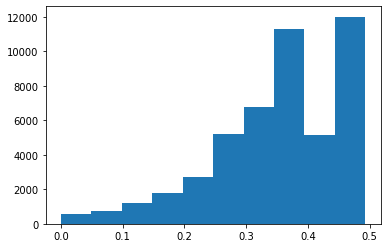

In [39]:
probs = expit(2*model4.predict(ds.fb13.X_test)).round(3)
accuracy_score(ds.fb13.y_test, probs>0.5)
plt.hist(probs)